NAME -- AAROHI SUDUMBREKAR
PROJECT NAME -- RESTORING IMAGES BY FEATURE LEARNING - INPAINTING

# IMPORTS

In [1]:
import skimage.io
import skimage.transform
import skimage.exposure
from PIL import ImageFile
import os
from glob import glob
import numpy as np
import pandas as pd
import ipdb
import tensorflow as tf
import pickle as cPickle
tf.compat.v1.disable_eager_execution()
import cv2
import matplotlib.pyplot as plt
#from tensorflow.python.keras.models 

1. Load Image 

In [7]:

def load_image(path, ori_height=146, ori_width=146, height=128, width=128 ):
    
    try:
        image = skimage.io.imread(path).astype(float)    
    except:
        return None

    image = image/255.

    if image is None: 
        return None
    if len(image.shape) < 2: 
        return None
    if len(image.shape) == 2: 
        image=np.tile(image[:,:,None], 3)
    if len(image.shape) == 4:
        return None
    if image.shape[2] == 4: 
        image=image[:,:,:3]
    if image.shape[2] > 4: 
        return None

    shortest_e = min( image.shape[:2] )
    y = int((image.shape[0] - shortest_e) / 2)
    x = int((image.shape[1] - shortest_e) / 2)
    crop_img = image[y:y+shortest_e, x:x+shortest_e]
    resize = skimage.transform.resize( crop_img, [ori_height,ori_width] )

    rand_y = np.random.randint(0, ori_height - height)
    rand_x = np.random.randint(0, ori_width - width)

    resize = resize[ rand_y:rand_y+height, rand_x:rand_x+width, : ]
    #get_resized_img = (resize*2)-1
    # get_resized_img= (resize + 1) / 2
    # get_resized_img= skimage.exposure.equalize_hist(resize)
    
    #plt.imshow(get_resized_img)

    return (resize * 2) -1


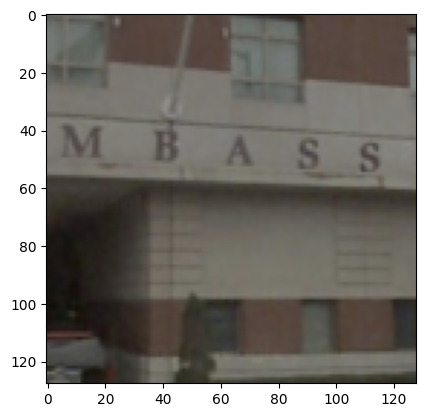

In [8]:
img = load_image('C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/svt1/train/01_16.jpg')
img = (img + 1) / 2
plt.imshow(img)
#plt.show()

2. Crop Image Function

In [9]:
def crop_central(image_ori, width=64,height=64, x=None, y=None, overlap=7):
    if image_ori is None: return None
    random_y = np.random.randint(overlap,height-overlap) if x is None else x
    random_x = np.random.randint(overlap,width-overlap) if y is None else y

    image = image_ori.copy()
    crop = image_ori.copy()
    crop = crop[random_y:random_y+height, random_x:random_x+width]
    image[random_y + overlap:random_y+height - overlap, random_x + overlap:random_x+width - overlap, 0] = 2*117. / 255. - 1.
    image[random_y + overlap:random_y+height - overlap, random_x + overlap:random_x+width - overlap, 1] = 2*104. / 255. - 1.
    image[random_y + overlap:random_y+height - overlap, random_x + overlap:random_x+width - overlap, 2] = 2*123. / 255. - 1.

    return image, crop, random_x, random_y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


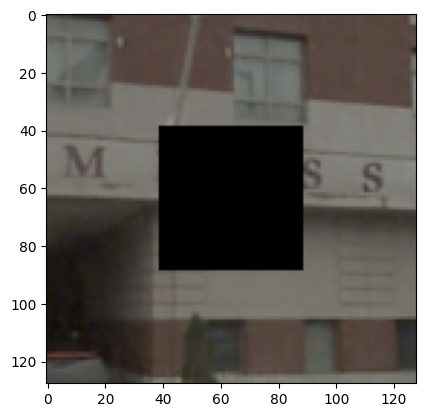

In [10]:
img  =  load_image('C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/svt1/train/01_16.jpg')
img = (img + 1) / 2
img, _, _, _ = crop_central(img,x=32,y=32)

plt.imshow(img)
plt.show()

# MODEL

In [47]:

# class Model():
#     def __init__(self):
#         pass
   
#     def conv_layer(self, bottom, filter_shape, activation=tf.identity, padding='SAME', stride=1, name=None):
#         with tf.name_scope(name):
#             w = tf.Variable(tf.random.normal(filter_shape, mean=0.0, stddev=0.005), name="W")
#             b = tf.Variable(tf.zeros(filter_shape[-1]), name="b")

#             conv = tf.nn.conv2d(bottom, w, strides=[1, stride, stride, 1], padding=padding)
#             bias = activation(tf.nn.bias_add(conv, b))

#         return bias

#     def deconv_layer(self, bottom, filter_shape, output_shape, activation=tf.identity, padding='SAME', stride=1, name=None):
#         with tf.name_scope(name):
#             W = tf.Variable(tf.random.normal(filter_shape, mean=0.0, stddev=0.005), name="W")
#             b = tf.Variable(tf.zeros(filter_shape[-2]), name="b")

#             deconv = tf.nn.conv2d_transpose(bottom, W, output_shape, strides=[1, stride, stride, 1], padding=padding)
#             bias = activation(tf.nn.bias_add(deconv, b))

#         return bias

#     def fully_conn_layer(self, bottom, output_size, name):
#         shape = bottom.shape.as_list()
#         dim = np.prod(shape[1:])
#         x = tf.reshape(bottom, [-1, dim])
#         input_size = dim

#         with tf.name_scope(name):
#             w = tf.Variable(tf.random.normal([input_size, output_size], mean=0.0, stddev=0.005), name="W")
#             b = tf.Variable(tf.zeros([output_size]), name="b")

#             fc = tf.nn.bias_add(tf.matmul(x, w), b)

#         return fc

#     def channel_wise_layer(self, input, name):
#         _, width, height, n_feat_map = input.shape.as_list()
#         input_reshape = tf.reshape(input, [-1, width * height, n_feat_map])
#         input_transpose = tf.transpose(input_reshape, [2, 0, 1])

#         with tf.name_scope(name):
#             W = tf.Variable(tf.random.normal([n_feat_map, width * height, width * height], mean=0.0, stddev=0.005), name="W")
#             output = tf.matmul(input_transpose, W)

#         output_transpose = tf.transpose(output, [1, 2, 0])
#         output_reshape = tf.reshape(output_transpose, [-1, height, width, n_feat_map])

#         return output_reshape

#     def leaky_relu(self, bottom, leak=0.1):
#         return tf.maximum(leak * bottom, bottom)

#     def batchnorm(self, bottom, is_train, epsilon=1e-8, name=None):
#         bottom = tf.clip_by_value(bottom, -100., 100.)
#         depth = bottom.shape.as_list()[-1]

#         with tf.name_scope(name):
#             gamma = tf.Variable(tf.ones(depth), name="gamma")
#             beta = tf.Variable(tf.zeros(depth), name="beta")

#             batch_mean, batch_var = tf.nn.moments(bottom, [0, 1, 2], name='moments')
#             ema = tf.train.ExponentialMovingAverage(decay=0.5)

#             def update():
#                 with tf.control_dependencies([ema_apply_op]):
#                     return tf.identity(batch_mean), tf.identity(batch_var)
                
#             ema_apply_op = ema.apply([batch_mean, batch_var])
#             ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
#             mean, var = tf.compat.v1.cond(
#                 is_train,
#                 update,
#                 lambda: (ema_mean, ema_var))

#             normed = tf.compat.v1.nn.batch_normalization(bottom, mean, var, beta, gamma, epsilon, False)
#             mean = tf.where(is_train, batch_mean, ema_mean)
#             var = tf.where(is_train, batch_var, ema_var)

#             normed = tf.nn.batch_normalization(bottom, mean, var, beta, gamma, epsilon)


#         return normed

    
#     def build_reconstruction( self, images, is_train ):
#         batch_size = images.get_shape().as_list()[0]

#         with tf.name_scope('GEN'):
#             conv1 = self.conv_layer(images, [4,4,3,64], stride=2, name="conv1" )
#             bn1 = self.leaky_relu(self.batchnorm(conv1, is_train, name='bn1'))
#             conv2 = self.conv_layer(bn1, [4,4,64,64], stride=2, name="conv2" )
#             bn2 = self.leaky_relu(self.batchnorm(conv2, is_train, name='bn2'))
#             conv3 = self.conv_layer(bn2, [4,4,64,128], stride=2, name="conv3")
#             bn3 = self.leaky_relu(self.batchnorm(conv3, is_train, name='bn3'))
#             conv4 = self.conv_layer(bn3, [4,4,128,256], stride=2, name="conv4")
#             bn4 = self.leaky_relu(self.batchnorm(conv4, is_train, name='bn4'))
#             conv5 = self.conv_layer(bn4, [4,4,256,512], stride=2, name="conv5")
#             bn5 = self.leaky_relu(self.batchnorm(conv5, is_train, name='bn5'))
#             conv6 = self.conv_layer(bn5, [4,4,512,4000], stride=2, padding='VALID', name='conv6')
#             bn6 = self.leaky_relu(self.batchnorm(conv6, is_train, name='bn6'))

#             deconv4 = self.deconv_layer( bn6, [4,4,512,4000], conv5.get_shape().as_list(), padding='VALID', stride=2, name="deconv4")
#             debn4 = tf.nn.relu(self.batchnorm(deconv4, is_train, name='debn4'))
#             deconv3 = self.deconv_layer( debn4, [4,4,256,512], conv4.get_shape().as_list(), stride=2, name="deconv3")
#             debn3 = tf.nn.relu(self.batchnorm(deconv3, is_train, name='debn3'))
#             deconv2 = self.deconv_layer( debn3, [4,4,128,256], conv3.get_shape().as_list(), stride=2, name="deconv2")
#             debn2 = tf.nn.relu(self.batchnorm(deconv2, is_train, name='debn2'))
#             deconv1 = self.deconv_layer( debn2, [4,4,64,128], conv2.get_shape().as_list(), stride=2, name="deconv1")
#             debn1 = tf.nn.relu(self.batchnorm(deconv1, is_train, name='debn1'))
#             recon = self.deconv_layer( debn1, [4,4,3,64], [batch_size,64,64,3], stride=2, name="recon")

#         return bn1, bn2, bn3, bn4, bn5, bn6, debn4, debn3, debn2, debn1, recon, tf.nn.tanh(recon)

#     def build_adversarial(self, images, is_train, reuse=None):
#         with tf.name_scope('DIS', reuse=reuse):
#             conv1 = self.conv_layer(images, [4,4,3,64], stride=2, name="conv1" )
#             bn1 = self.leaky_relu(self.batchnorm(conv1, is_train, name='bn1'))
#             conv2 = self.conv_layer(bn1, [4,4,64,128], stride=2, name="conv2")
#             bn2 = self.leaky_relu(self.batchnorm(conv2, is_train, name='bn2'))
#             conv3 = self.conv_layer(bn2, [4,4,128,256], stride=2, name="conv3")
#             bn3 = self.leaky_relu(self.batchnorm(conv3, is_train, name='bn3'))
#             conv4 = self.conv_layer(bn3, [4,4,256,512], stride=2, name="conv4")
#             bn4 = self.leaky_relu(self.batchnorm(conv4, is_train, name='bn4'))

#             output = self.fully_conn_layer( bn4, output_size=1, name='output')

#         return output[:,0]


In [11]:
class Model():
    def __init__(self):
           pass
   
    def conv_layer( self, bottom, filter_shape, activation=tf.identity, padding='SAME', stride=1, name=None ):
        with tf.name_scope(name):
            w = tf.Variable(tf.random.normal(filter_shape, mean=0.0, stddev=0.005), name="W")
            b = tf.Variable(tf.zeros(filter_shape[-1]), name="b")

            conv = tf.nn.conv2d(bottom, w, strides=[1, stride, stride, 1], padding=padding)
            bias = activation(tf.nn.bias_add(conv, b))
        

        return bias 

    def deconv_layer(self, bottom, filter_shape, output_shape, activation=tf.identity, padding='SAME', stride=1, name=None):
        with tf.name_scope(name):
            W = tf.Variable(tf.random.normal(filter_shape, mean=0.0, stddev=0.005), name="W")
            b = tf.Variable(tf.zeros(filter_shape[-2]), name="b")

            deconv = tf.nn.conv2d_transpose(bottom, W, output_shape, strides=[1, stride, stride, 1], padding=padding)
            bias = activation(tf.nn.bias_add(deconv, b))
       
        return bias

    def fully_conn_layer( self, bottom, output_size, name ):
        shape = bottom.get_shape().as_list()
        dim = np.prod( shape[1:] )
        x = tf.reshape( bottom, [-1, dim])
        input_size = dim

        with tf.name_scope(name):
            w = tf.Variable(tf.random.normal([input_size, output_size], mean=0.0, stddev=0.005), name="W")
            b = tf.Variable(tf.zeros([output_size]), name="b")

            fully_conn = tf.compat.v1.nn.bias_add( tf.matmul(x, w), b)

        return fully_conn

    # (7x7x512)
    def channel_wise_layer(self, input, name): 
        _, width, height, n_feat_map = input.get_shape().as_list()
        input_reshape = tf.reshape( input, [-1, width*height, n_feat_map] )
        input_transpose = tf.transpose( input_reshape, [2,0,1] )

        with tf.name_scope(name):
            W = tf.Variable(tf.random.normal([n_feat_map, width * height, width * height], mean=0.0, stddev=0.005), name="W")
            output = tf.matmul(input_transpose, W)

        output_transpose = tf.transpose(output, [1,2,0])
        output_reshape = tf.reshape( output_transpose, [-1, height, width, n_feat_map] )

        return output_reshape

    def leaky_relu(self, bottom, leak=0.1):
        return tf.maximum(leak*bottom, bottom)

    def batchnorm(self, bottom, is_train, epsilon=1e-8, name=None):
        bottom = tf.clip_by_value( bottom, -100., 100.)
        depth = bottom.get_shape().as_list()[-1]

        with tf.compat.v1.variable_scope(name):

            gamma = tf.compat.v1.get_variable("gamma", [depth], initializer=tf.constant_initializer(1.))
            beta  = tf.compat.v1.get_variable("beta" , [depth], initializer=tf.constant_initializer(0.))

            batch_mean, batch_var = tf.nn.moments(bottom, [0,1,2], name='moments')
            ema = tf.compat.v1.train.ExponentialMovingAverage(decay=0.5)


            def update():
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(batch_mean), tf.identity(batch_var)

            ema_apply_op = ema.apply([batch_mean, batch_var])
            ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
            mean, var = tf.cond(
                    is_train,
                    update,
                    lambda: (ema_mean, ema_var) )

            normed = tf.compat.v1.nn.batch_norm_with_global_normalization(bottom, mean, var, beta, gamma, epsilon, False)
        return normed

    def reconstruction_loss( self, images, is_train ):
        batch_size = images.get_shape().as_list()[0]

        with tf.compat.v1.variable_scope('GENERATOR3',reuse=tf.compat.v1.AUTO_REUSE):
            conv_layer1 = self.conv_layer(images, [4,4,3,64], stride=2, name="c1" )
            batch_norm1 = self.leaky_relu(self.batchnorm(conv_layer1, is_train, name='BN1'))
            conv_layer2 = self.conv_layer(batch_norm1, [4,4,64,64], stride=2, name="c2" )
            batch_norm2 = self.leaky_relu(self.batchnorm(conv_layer2, is_train, name='BN2'))
            conv_layer3 = self.conv_layer(batch_norm2, [4,4,64,128], stride=2, name="c3")
            batch_norm3 = self.leaky_relu(self.batchnorm(conv_layer3, is_train, name='BN3'))
            conv_layer4 = self.conv_layer(batch_norm3, [4,4,128,256], stride=2, name="c4")
            batch_norm4 = self.leaky_relu(self.batchnorm(conv_layer4, is_train, name='BN4'))
            conv_layer5 = self.conv_layer(batch_norm4, [4,4,256,512], stride=2, name="c5")
            batch_norm5 = self.leaky_relu(self.batchnorm(conv_layer5, is_train, name='BN5'))
            conv_layer6 = self.conv_layer(batch_norm5, [4,4,512,4000], stride=2, padding='VALID', name='c6')
            batch_norm6 = self.leaky_relu(self.batchnorm(conv_layer6, is_train, name='BN6'))

            de_conv_layer4 = self.deconv_layer(batch_norm6, [4,4,512,4000], conv_layer5.get_shape().as_list(), padding='VALID', stride=2, name="d4")
            de_batch_norm4 = tf.nn.relu(self.batchnorm(de_conv_layer4, is_train, name='DBN4'))
            de_conv_layer3 = self.deconv_layer(de_batch_norm4, [4,4,256,512], conv_layer4.get_shape().as_list(), stride=2, name="d3")
            de_batch_norm3 = tf.nn.relu(self.batchnorm(de_conv_layer3, is_train, name='DBN3'))
            de_conv_layer2 = self.deconv_layer(de_batch_norm3, [4,4,128,256], conv_layer3.get_shape().as_list(), stride=2, name="d2")
            de_batch_norm2 = tf.nn.relu(self.batchnorm(de_conv_layer2, is_train, name='DBN2'))
            de_conv_layer1 = self.deconv_layer(de_batch_norm2, [4,4,64,128], conv_layer2.get_shape().as_list(), stride=2, name="d1")
            de_batch_norm1 = tf.nn.relu(self.batchnorm(de_conv_layer1, is_train, name='DBN1'))
            recon = self.deconv_layer(de_batch_norm1, [4,4,3,64], [batch_size,64,64,3], stride=2, name="recon")

        return batch_norm1, batch_norm2, batch_norm3, batch_norm4, batch_norm5, batch_norm6, de_batch_norm4, de_batch_norm3, de_batch_norm2, de_batch_norm1, recon, tf.nn.tanh(recon)

    def adversarial_loss(self, images, is_train, reuse=True):
        with tf.compat.v1.variable_scope('DISCRIMINATOR3', reuse=tf.compat.v1.AUTO_REUSE):
            conv_layer1 = self.conv_layer(images, [4,4,3,64], stride=2, name="c1" )
            batch_norm1 = self.leaky_relu(self.batchnorm(conv_layer1, is_train, name='BN1'))
            conv_layer2 = self.conv_layer(batch_norm1, [4,4,64,128], stride=2, name="c2")
            batch_norm2 = self.leaky_relu(self.batchnorm(conv_layer2, is_train, name='BN2'))
            conv_layer3 = self.conv_layer(batch_norm2, [4,4,128,256], stride=2, name="c3")
            batch_norm3 = self.leaky_relu(self.batchnorm(conv_layer3, is_train, name='BN3'))
            conv_layer4 = self.conv_layer(batch_norm3, [4,4,256,512], stride=2, name="c4")
            batch_norm4 = self.leaky_relu(self.batchnorm(conv_layer4, is_train, name='BN4'))

            output = self.fully_conn_layer(batch_norm4, output_size=1, name='output')

        return output[:,0]

# TRAIN IMAGES  

In [12]:
n_epochs = 10
learning_rate_val = 0.0003
weight_decay_rate =  0.0001
momentum = 0.9
batch_size = 100
lambda_recon = 0.999
lambda_adv = 0.001

overlap_size = 7
hiding_size = 64

In [13]:
trainset_path = 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/svt1/train.pickle'
testset_path  = 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/svt1/test.pickle'
dataset_path = 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/svt1/'
model_path = 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/models/'
result_path= 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/results/'
pretrained_model_path = None

In [14]:
if not os.path.exists(model_path):
    os.makedirs( model_path )

if not os.path.exists(result_path):
    os.makedirs( result_path )

if not os.path.exists( trainset_path ) or not os.path.exists( testset_path ):
    
    trainset_dir = os.path.join( dataset_path, 'train' )
    testset_dir = os.path.join( dataset_path, 'test' )

    trainset = pd.DataFrame({'image_path': map(lambda x: os.path.join( trainset_dir, x ), os.listdir(trainset_dir))})
    testset = pd.DataFrame({'image_path': map(lambda x: os.path.join( testset_dir, x ), os.listdir(testset_dir))})

    trainset.to_pickle( trainset_path )
    testset.to_pickle( testset_path )
else:
    trainset = pd.read_pickle( trainset_path )
    testset = pd.read_pickle( testset_path )


In [15]:
print(len(testset))
testset.index = range(len(testset))
testset = testset.iloc[np.random.permutation(len(testset))]
is_train = tf.compat.v1.placeholder(tf.bool )

learning_rate = tf.compat.v1.placeholder(tf.float32, [])
images_tf = tf.compat.v1.placeholder(tf.float32, [batch_size, 128, 128, 3], name="images")
print(images_tf)
labels_D = tf.concat([tf.ones([batch_size]), tf.zeros([batch_size])], axis=0)
labels_G = tf.ones([batch_size])
print(labels_D,labels_G)
images_hiding = tf.compat.v1.placeholder( tf.float32, [batch_size, hiding_size, hiding_size, 3], name='images_hiding')

101
Tensor("images:0", shape=(100, 128, 128, 3), dtype=float32)
Tensor("concat:0", shape=(200,), dtype=float32) Tensor("ones_1:0", shape=(100,), dtype=float32)


In [16]:
model = Model()

batch_norm1, batch_norm2, batch_norm3, batch_norm4, batch_norm5, batch_norm6, de_batch_norm4, de_batch_norm3, de_batch_norm2, de_batch_norm1, reconstruction_ori, reconstruction = model.reconstruction_loss(images_tf, is_train)
adversarial_pos = model.adversarial_loss(images_hiding, is_train)
adversarial_neg = model.adversarial_loss(reconstruction, is_train, reuse=True)

adversarial_pos = tf.expand_dims(adversarial_pos, axis=0)
adversarial_neg = tf.expand_dims(adversarial_neg, axis=0)
adversarial_all = tf.concat([adversarial_pos, adversarial_neg], axis=0)
tf.rank(adversarial_all)
print(adversarial_all.shape)



(2, 100)


In [17]:

masking_reconst = tf.pad(tf.ones([hiding_size - 2*overlap_size, hiding_size - 2*overlap_size]), [[overlap_size,overlap_size], [overlap_size,overlap_size]])

masking_reconst = tf.expand_dims(masking_reconst, axis=-1)
print(masking_reconst.shape)
masking_reconst = tf.concat([masking_reconst]*3, axis=-1)
masking_overlap = 1 - masking_reconst

(64, 64, 1)


In [18]:
recon_loss_ori = tf.square( images_hiding - reconstruction )
recon_loss_central = tf.reduce_mean(tf.sqrt( 1e-5 + tf.reduce_sum(recon_loss_ori * masking_reconst, [1,2,3])))  # Loss for non-overlapping region
recon_loss_overlap = tf.reduce_mean(tf.sqrt( 1e-5 + tf.reduce_sum(recon_loss_ori * masking_overlap, [1,2,3]))) * 10. # Loss for overlapping region
recon_loss = recon_loss_central + recon_loss_overlap

adversarial_all = tf.reshape(adversarial_all, [-1])
adversarial_neg = tf.reshape(adversarial_neg, [-1])
loss_adv_D = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(adversarial_all, labels_D))
loss_adv_G = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(adversarial_neg, labels_G))

loss_G = loss_adv_G * lambda_adv + recon_loss * lambda_recon
loss_D = loss_adv_D 

In [19]:

var_G = list(filter(lambda x: x.name.startswith('GENERATOR'), tf.compat.v1.trainable_variables()))
var_D = list(filter(lambda x: x.name.startswith('DISCRIMINATOR'), tf.compat.v1.trainable_variables()))

W_G = list(filter(lambda x: x.name.endswith('W:0'), var_G))
W_D = list(filter(lambda x: x.name.endswith('W:0'), var_D))

loss_G += weight_decay_rate * tf.reduce_mean(tf.stack(list(map(lambda x: tf.nn.l2_loss(x), W_G))))
loss_D += weight_decay_rate * tf.reduce_mean(tf.stack(list(map(lambda x: tf.nn.l2_loss(x), W_D))))

gpu = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4)
sess = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu))

optimizer_G = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5)
grads_vars_G = optimizer_G.compute_gradients(loss_G, var_list=var_G)
train_op_G = optimizer_G.apply_gradients(grads_vars_G)
optimizer_D = tf.compat.v1.train.AdamOptimizer( learning_rate=learning_rate, beta1=0.5 )
grads_vars_D = optimizer_D.compute_gradients( loss_D, var_list=var_D )
train_op_D = optimizer_D.apply_gradients( grads_vars_D )
saver = tf.compat.v1.train.Saver(max_to_keep=100)
# substitute to keras
tf.compat.v1.global_variables_initializer().run()

#sess.close()

In [ ]:
tf.config.list_physical_devices('GPU')

In [21]:
if pretrained_model_path is not None and os.path.exists( pretrained_model_path ):
    saver.restore( sess, pretrained_model_path )

i = 0

loss_D_val = 0.
loss_G_val = 0.
loss_G_ad_rec = []
loss_D_adv = []
print(len(trainset))
for epoch in range(n_epochs):
    trainset.index = range(len(trainset))
    trainset = trainset.iloc[np.random.permutation(len(trainset))]

    for start,end in zip(
            range(0, len(trainset), batch_size),
            range(batch_size, len(trainset), batch_size)):

        image_paths = trainset[start:end]['image_path'].values
        images_ori = map(lambda x: load_image( x ), image_paths)

        images_crops = map(lambda x: crop_central(x), images_ori)
        images, crops,_,_ = zip(*images_crops)


        if i % 5 == 0:
            test_image_paths = testset[:batch_size]['image_path'].values
            test_images_ori = map(lambda x: load_image(x), test_image_paths)

            test_images_crop = map(lambda x: crop_central(x, x=32, y=32), test_images_ori)
            test_images, test_crops, xs,ys = zip(*test_images_crop)

            reconstruction_vals, recon_ori_vals, bn1_val,bn2_val,bn3_val,bn4_val,bn5_val,bn6_val,debn4_val, debn3_val, debn2_val, debn1_val, loss_G_val, loss_D_val = sess.run(
                    [reconstruction, reconstruction_ori, batch_norm1,batch_norm2,batch_norm3,batch_norm4,batch_norm5,batch_norm6,de_batch_norm4, de_batch_norm3, de_batch_norm2, de_batch_norm1, loss_G, loss_D],
                    feed_dict={
                        images_tf: test_images,
                        images_hiding: test_crops,
                        is_train: False
                        })

            # Get result after 5 iterations
            if i % 5 == 0:
                img_no = 0
                for rec_val, img,x,y in zip(reconstruction_vals, test_images, xs, ys):
                    rec_hid = (255. * (rec_val+1)/2.).astype(int)
                    rec_con = (255. * (img+1)/2.).astype(int)

                    rec_con[y:y+64, x:x+64] = rec_hid
                    cv2.imwrite( os.path.join(result_path, 'img_'+str(img_no)+'.'+str(int(i/1000))+'.jpg'), rec_con)
                    img_no += 1
                    if img_no > 50: break

            print("Loss parameter Values at each operation: ")
            print(bn1_val.max(), bn1_val.min())
            print(bn2_val.max(), bn2_val.min())
            print(bn3_val.max(), bn3_val.min())
            print(bn4_val.max(), bn4_val.min())
            print(bn5_val.max(), bn5_val.min())
            print(bn6_val.max(), bn6_val.min())
            print(debn4_val.max(), debn4_val.min())
            print(debn3_val.max(), debn3_val.min())
            print(debn2_val.max(), debn2_val.min())
            print(debn1_val.max(), debn1_val.min())
            print(recon_ori_vals.max(), recon_ori_vals.min())
            print(reconstruction_vals.max(), reconstruction_vals.min())
            print(loss_G_val, loss_D_val)
            print('\n')

            if np.isnan(reconstruction_vals.min() ) or np.isnan(reconstruction_vals.max()):
                print("NaN detected!!")
                ipdb.set_trace()

       
        _, loss_G_val, adv_pos_val, adv_neg_val, loss_recon_val, loss_adv_G_val, reconstruction_vals, recon_ori_vals, bn1_val,bn2_val,bn3_val,bn4_val,bn5_val,bn6_val,debn4_val, debn3_val, debn2_val, debn1_val = sess.run(
                [train_op_G, loss_G, adversarial_pos, adversarial_neg,recon_loss, loss_adv_G, reconstruction, reconstruction_ori, batch_norm1,batch_norm2,batch_norm3,batch_norm4,batch_norm5,batch_norm6,de_batch_norm4, de_batch_norm3, de_batch_norm2, de_batch_norm1],
                feed_dict={
                    images_tf: images,
                    images_hiding: crops,
                    learning_rate: learning_rate_val,
                    is_train: True
                    })

        loss_G_ad_rec.append(loss_G_val)
        loss_D_adv.append(loss_D_val)
        # Discriminator of GAN is updated only once in 10 iterations
        if i % 5  == 0:
            _, loss_D_val, adv_pos_val, adv_neg_val = sess.run(
                    [train_op_D, loss_D, adversarial_pos, adversarial_neg],
                    feed_dict={
                        images_tf: images,
                        images_hiding: crops,
                        learning_rate: learning_rate_val,
                        is_train: True
                        })

            print("Iter:", i, "Gen Loss:", loss_G_val, "Recon Loss:", loss_recon_val, "Gen ADV Loss:", loss_adv_G_val,  "Dis Loss:", loss_D_val, "||||", adv_pos_val.mean(), adv_neg_val.min(), adv_neg_val.max())

        i += 1


    saver.save(sess, model_path + 'model', global_step=epoch)
    learning_rate_val *= 0.99
plt.plot(range(len(loss_D_adv)), loss_D_adv, label='Adversarial Loss')
plt.plot(range(len(loss_G_ad_rec)), loss_G_ad_rec, label='Reconstruction + Adversarial Loss')
#plt.plot(range(len(recon_losses)), recon_losses, label='Reconstruction Loss')
plt.legend()
plt.show()


249
11.127024 -1.136246
11.0073185 -1.0854402
10.252618 -0.9635474
8.196533 -0.9568154
12.195358 -0.7607328
6.155272 -0.5384464
5.7518435 0.0
6.972972 0.0
6.9894347 0.0
8.593058 0.0
0.3573077 -0.35776812
0.34284037 -0.34324658
394.40234 0.98744935
Iter: 0 Gen Loss: 391.2775 Recon Loss: 391.65988 Gen ADV Loss: 1.1763037 Dis Loss: 1.0175178 |||| -0.027244346 -0.6061722 0.44292915


UnknownError: Graph execution error:

Detected at node 'save/SaveV2' defined at (most recent call last):
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Aarohi Sudumbrekar\AppData\Local\Temp\ipykernel_40964\3613241417.py", line 23, in <module>
      saver = tf.compat.v1.train.Saver(max_to_keep=100)
Node: 'save/SaveV2'
Failed to WriteFile: \\?\C:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\models_test\model-0.data-00000-of-00001.tempstate11035779456746821808 : There is not enough space on the disk.
; operation in progress
	 [[{{node save/SaveV2}}]]

Original stack trace for 'save/SaveV2':
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
    self.io_loop.start()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
    self._run_once()
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
    handle._run()
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
    await self.process_one()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
    await dispatch(*args)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
    await result
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
    reply_content = await reply_content
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
    res = shell.run_cell(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
    return super().run_cell(*args, **kwargs)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
    result = self._run_cell(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
    result = runner(coro)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Aarohi Sudumbrekar\AppData\Local\Temp\ipykernel_40964\3613241417.py", line 23, in <module>
    saver = tf.compat.v1.train.Saver(max_to_keep=100)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\training\saver.py", line 934, in __init__
    self.build()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\training\saver.py", line 946, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\training\saver.py", line 974, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\training\saver.py", line 541, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\training\saver.py", line 230, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\training\saver.py", line 145, in save_op
    return io_ops.save_v2(filename_tensor, tensor_names, tensor_slices,
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1846, in save_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 795, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\framework\ops.py", line 3814, in _create_op_internal
    ret = Operation(


# TEST IMAGES

In [32]:
n_epochs = 10
learning_rate_val = 0.001
weight_decay_rate = 0.00001
momentum = 0.9
batch_size = 100
lambda_recon = 0.999
lambda_adv = 0.001

overlap_size = 7
hiding_size = 64

In [21]:
import tensorflow as tf
a = tf.Variable(1.0)
b = tf.Variable(2.0)

# Initialize all variables from train session
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
# check whther the checkpoint-file exists
ckpt = tf.train.Checkpoint(var_list={'a': a, 'b': b})
ckpt_path = ckpt.save('C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/tmp-ckpt')

reader = tf.train.load_checkpoint(ckpt_path)
print(reader.get_tensor('var_list/a/.ATTRIBUTES/VARIABLE_VALUE'))


FailedPreconditionError: Graph execution error:

Detected at node 'Read_4/ReadVariableOp' defined at (most recent call last):
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Aarohi Sudumbrekar\AppData\Local\Temp\ipykernel_35520\102451323.py", line 10, in <module>
      ckpt_path = ckpt.save('C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/tmp-ckpt')
Node: 'Read_4/ReadVariableOp'
Could not find variable Variable_2. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status error message=Resource localhost/Variable_2/class tensorflow::Var does not exist.
	 [[{{node Read_4/ReadVariableOp}}]]

Original stack trace for 'Read_4/ReadVariableOp':
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
    self.io_loop.start()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
    self._run_once()
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
    handle._run()
  File "C:\Users\Aarohi Sudumbrekar\anaconda3\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
    await self.process_one()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
    await dispatch(*args)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
    await result
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
    reply_content = await reply_content
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
    res = shell.run_cell(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
    return super().run_cell(*args, **kwargs)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
    result = self._run_cell(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
    result = runner(coro)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Aarohi Sudumbrekar\AppData\Local\Temp\ipykernel_35520\102451323.py", line 10, in <module>
    ckpt_path = ckpt.save('C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/tmp-ckpt')
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\checkpoint\checkpoint.py", line 2409, in save
    return self._write(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\checkpoint\checkpoint.py", line 2291, in _write
    output = self._saver.save(file_prefix=file_prefix, options=options)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\checkpoint\checkpoint.py", line 1304, in save
    save_path, new_feed_additions = self._save_cached_when_graph_building(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\checkpoint\checkpoint.py", line 1242, in _save_cached_when_graph_building
    save_op = saver.save(file_prefix, options=options)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\checkpoint\functional_saver.py", line 407, in save
    return save_fn()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\checkpoint\functional_saver.py", line 381, in save_fn
    sharded_saves.append(saver.save(shard_prefix, options))
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\checkpoint\functional_saver.py", line 68, in save
    tensor_value = tensor.tensor
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\training\saving\saveable_object.py", line 53, in tensor
    return self._tensor() if callable(self._tensor) else self._tensor
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 699, in _read_variable_closure
    x = v.read_value_no_copy()
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 790, in read_value_no_copy
    value = self._read_variable_op(no_copy=True)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 753, in _read_variable_op
    result = read_and_set_handle(no_copy)
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 743, in read_and_set_handle
    result = gen_resource_variable_ops.read_variable_op(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\ops\gen_resource_variable_ops.py", line 594, in read_variable_op
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 795, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\framework\ops.py", line 3814, in _create_op_internal
    ret = Operation(


In [ ]:
ckpt_path = "C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/models/checkpoint"

vars_list = tf.train.list_variables(ckpt_path)
for var in vars_list:
    print(var)

In [ ]:
checkpoint_path = "C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/models/checkpoint"
if os.path.exists(checkpoint_path):
    print("Checkpoint file exists.")
else:
    print("Checkpoint file does not exist.")

try:
    reader = tf.train.load_checkpoint(checkpoint_path)
    var_to_shape_map = reader.get_variable_to_shape_map()
except Exception as e:
    print("Error reading checkpoint file: ", str(e))
else:
    # Check the integrity of the variables
    try:
        tf.train.init_from_checkpoint(checkpoint_path, assignment_map=var_to_shape_map)
    except Exception as e:
        print("Integrity check failed: ", str(e))
    else:
        print("Integrity check successful.")
# saver = tf.compat.v1.train.Saver()
# with tf.compat.v1.Session() as sess:
#     # Restore the checkpoint
#     saver.restore(sess, 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/models/checkpoint')


c:\Users\Aarohi Sudumbrekar\Desktop\dl_project-1\envp\env\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/models/model-99


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


trt
Yes
[[[0.36078431 0.38039216 0.49411765]
  [0.39215686 0.41176471 0.5254902 ]
  [0.37647059 0.40392157 0.51372549]
  ...
  [0.30588235 0.3254902  0.4745098 ]
  [0.26666667 0.28235294 0.45882353]
  [0.40392157 0.41960784 0.60784314]]

 [[0.35294118 0.37254902 0.48627451]
  [0.38431373 0.40392157 0.51764706]
  [0.36862745 0.39607843 0.50588235]
  ...
  [0.36470588 0.38823529 0.52941176]
  [0.51372549 0.52941176 0.70588235]
  [0.23921569 0.25490196 0.43921569]]

 [[0.37254902 0.4        0.50980392]
  [0.39607843 0.42352941 0.53333333]
  [0.37254902 0.4        0.50980392]
  ...
  [0.25098039 0.2745098  0.40784314]
  [0.39215686 0.41176471 0.57647059]
  [0.39607843 0.41176471 0.58823529]]

 ...

 [[0.54509804 0.57254902 0.61176471]
  [0.58039216 0.60784314 0.64705882]
  [0.56470588 0.59215686 0.63137255]
  ...
  [0.52941176 0.54509804 0.58039216]
  [0.55686275 0.57254902 0.60784314]
  [0.54117647 0.55686275 0.59215686]]

 [[0.54509804 0.57254902 0.61176471]
  [0.57254902 0.6        0.63

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.50196078 0.55686275 0.65882353]
  [0.51372549 0.56862745 0.67058824]
  [0.48627451 0.54117647 0.64313725]
  ...
  [0.47058824 0.51372549 0.63137255]
  [0.29019608 0.32941176 0.46666667]
  [0.34901961 0.38823529 0.52941176]]

 [[0.47843137 0.53333333 0.63529412]
  [0.50588235 0.56078431 0.6627451 ]
  [0.49411765 0.54901961 0.65098039]
  ...
  [0.39215686 0.43529412 0.54509804]
  [0.45882353 0.49803922 0.63529412]
  [0.30588235 0.34509804 0.48235294]]

 [[0.48627451 0.54117647 0.64313725]
  [0.51372549 0.56862745 0.67058824]
  [0.50196078 0.55686275 0.65882353]
  ...
  [0.38823529 0.43529412 0.5372549 ]
  [0.43529412 0.47843137 0.60392157]
  [0.29019608 0.33333333 0.45882353]]

 ...

 [[0.47843137 0.43921569 0.43137255]
  [0.50980392 0.47058824 0.4627451 ]
  [0.52941176 0.49019608 0.48235294]
  ...
  [0.05882353 0.06666667 0.0627451 ]
  [0.0627451  0.07843137 0.0745098 ]
  [0.07058824 0.08627451 0.08235294]]

 [[0.48627451 0.44705882 0.44313725]
  [0.49803922 0.45882353 0.45490196]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.24313725 0.23137255 0.19607843]
  [0.24313725 0.23137255 0.19607843]
  [0.24705882 0.23529412 0.2       ]
  ...
  [0.71764706 0.6        0.45882353]
  [0.71764706 0.6        0.46666667]
  [0.71764706 0.6        0.46666667]]

 [[0.24705882 0.23529412 0.2       ]
  [0.25098039 0.23921569 0.20392157]
  [0.25098039 0.23921569 0.20392157]
  ...
  [0.71764706 0.6        0.45882353]
  [0.71764706 0.6        0.46666667]
  [0.71764706 0.6        0.46666667]]

 [[0.25098039 0.23921569 0.21176471]
  [0.25490196 0.24313725 0.21568627]
  [0.25490196 0.24313725 0.21568627]
  ...
  [0.72156863 0.60392157 0.4627451 ]
  [0.71764706 0.6        0.45882353]
  [0.71764706 0.6        0.45882353]]

 ...

 [[0.36078431 0.35686275 0.34117647]
  [0.36078431 0.35686275 0.34117647]
  [0.36078431 0.35686275 0.34117647]
  ...
  [0.3254902  0.28627451 0.24705882]
  [0.32941176 0.29019608 0.25490196]
  [0.34509804 0.30588235 0.27058824]]

 [[0.36078431 0.35686275 0.34117647]
  [0.36078431 0.35686275 0.34117647]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.39215686 0.41176471 0.39607843]
  [0.39607843 0.41568627 0.4       ]
  [0.39607843 0.41568627 0.4       ]
  ...
  [0.35294118 0.30980392 0.30196078]
  [0.34901961 0.30196078 0.30196078]
  [0.34901961 0.30196078 0.30196078]]

 [[0.38823529 0.40784314 0.39215686]
  [0.39215686 0.41176471 0.39607843]
  [0.39215686 0.41176471 0.39607843]
  ...
  [0.34901961 0.30588235 0.29803922]
  [0.34901961 0.30196078 0.30196078]
  [0.34901961 0.30196078 0.30196078]]

 [[0.38823529 0.40784314 0.39215686]
  [0.38823529 0.40784314 0.39215686]
  [0.39215686 0.41176471 0.39607843]
  ...
  [0.34901961 0.30588235 0.29803922]
  [0.34901961 0.30588235 0.29803922]
  [0.34901961 0.30588235 0.29803922]]

 ...

 [[0.36470588 0.37254902 0.35294118]
  [0.36470588 0.37254902 0.35294118]
  [0.36470588 0.37254902 0.35294118]
  ...
  [0.30196078 0.30980392 0.29803922]
  [0.29019608 0.29803922 0.29411765]
  [0.28627451 0.29411765 0.29019608]]

 [[0.37254902 0.38039216 0.36078431]
  [0.37647059 0.38431373 0.36470588]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.58039216 0.4627451  0.43137255]
  [0.57254902 0.45490196 0.42352941]
  [0.59215686 0.45490196 0.43137255]
  ...
  [0.16862745 0.16862745 0.16078431]
  [0.15686275 0.15686275 0.14901961]
  [0.14509804 0.14509804 0.1372549 ]]

 [[0.58823529 0.47058824 0.43921569]
  [0.57647059 0.44705882 0.41960784]
  [0.57647059 0.43921569 0.41568627]
  ...
  [0.16078431 0.16078431 0.15294118]
  [0.15294118 0.15294118 0.14509804]
  [0.18431373 0.18431373 0.17647059]]

 [[0.55686275 0.42745098 0.40784314]
  [0.54901961 0.41960784 0.4       ]
  [0.55294118 0.41568627 0.39215686]
  ...
  [0.16470588 0.16470588 0.15686275]
  [0.18039216 0.18039216 0.17254902]
  [0.15294118 0.15294118 0.14509804]]

 ...

 [[0.60392157 0.4627451  0.4       ]
  [0.61960784 0.4745098  0.41176471]
  [0.62745098 0.4627451  0.40784314]
  ...
  [0.54509804 0.31764706 0.2627451 ]
  [0.55686275 0.32156863 0.27843137]
  [0.54901961 0.32156863 0.2745098 ]]

 [[0.63921569 0.5254902  0.4627451 ]
  [0.63921569 0.51764706 0.44705882]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.20392157 0.17647059 0.14509804]
  [0.2        0.17254902 0.14117647]
  [0.19215686 0.17647059 0.14117647]
  ...
  [0.31372549 0.2745098  0.27058824]
  [0.3254902  0.28627451 0.27843137]
  [0.31372549 0.2745098  0.26666667]]

 [[0.20392157 0.17647059 0.14509804]
  [0.2        0.17254902 0.14117647]
  [0.19607843 0.18039216 0.14509804]
  ...
  [0.32941176 0.29019608 0.28627451]
  [0.31372549 0.2745098  0.26666667]
  [0.34901961 0.30980392 0.30196078]]

 [[0.2        0.17254902 0.14117647]
  [0.2        0.17254902 0.14117647]
  [0.19215686 0.17647059 0.14117647]
  ...
  [0.34117647 0.30980392 0.30196078]
  [0.38039216 0.34901961 0.3372549 ]
  [0.36078431 0.32941176 0.31764706]]

 ...

 [[0.38039216 0.41960784 0.38431373]
  [0.39215686 0.43137255 0.39607843]
  [0.38431373 0.42352941 0.38823529]
  ...
  [0.2745098  0.31372549 0.41960784]
  [0.28235294 0.3254902  0.41176471]
  [0.34117647 0.38431373 0.47058824]]

 [[0.39215686 0.43137255 0.4       ]
  [0.38823529 0.42745098 0.39607843]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.84313725 0.8627451  0.9372549 ]
  [0.         0.00392157 0.07843137]
  [0.80784314 0.82745098 0.90196078]
  ...
  [0.         0.00784314 0.07843137]
  [0.88235294 0.90980392 0.98039216]
  [0.         0.00784314 0.07843137]]

 [[0.4        0.42745098 0.50196078]
  [0.43529412 0.4627451  0.5372549 ]
  [0.38431373 0.41176471 0.48627451]
  ...
  [0.49411765 0.52941176 0.59607843]
  [0.43137255 0.45882353 0.52941176]
  [0.47843137 0.51372549 0.58039216]]

 [[0.41960784 0.4627451  0.54117647]
  [0.43529412 0.47843137 0.55686275]
  [0.45882353 0.50196078 0.58039216]
  ...
  [0.50196078 0.54509804 0.61568627]
  [0.50980392 0.54117647 0.61568627]
  [0.50196078 0.54509804 0.61568627]]

 ...

 [[0.36078431 0.33333333 0.30980392]
  [0.36862745 0.34117647 0.31764706]
  [0.37647059 0.34901961 0.3254902 ]
  ...
  [0.87843137 0.89411765 0.92941176]
  [0.88235294 0.89411765 0.92941176]
  [0.88627451 0.89803922 0.93333333]]

 [[0.56470588 0.55294118 0.53333333]
  [0.57254902 0.56078431 0.54117647]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.05882353 0.09803922 0.06666667]
  [0.05882353 0.09803922 0.06666667]
  [0.05882353 0.09803922 0.06666667]
  ...
  [0.15294118 0.16078431 0.14117647]
  [0.17647059 0.18431373 0.16470588]
  [0.20392157 0.21176471 0.19215686]]

 [[0.05882353 0.09803922 0.06666667]
  [0.0627451  0.10196078 0.07058824]
  [0.05882353 0.09803922 0.06666667]
  ...
  [0.10196078 0.10980392 0.09019608]
  [0.17254902 0.18039216 0.16078431]
  [0.23921569 0.24705882 0.22745098]]

 [[0.0627451  0.10196078 0.07058824]
  [0.0627451  0.10196078 0.07058824]
  [0.06666667 0.09411765 0.06666667]
  ...
  [0.18431373 0.19215686 0.17254902]
  [0.17254902 0.18039216 0.16078431]
  [0.13333333 0.14117647 0.12156863]]

 ...

 [[0.53333333 0.5372549  0.51764706]
  [0.52156863 0.5254902  0.50588235]
  [0.54509804 0.54901961 0.52941176]
  ...
  [0.25490196 0.23529412 0.22352941]
  [0.27058824 0.23921569 0.23137255]
  [0.2627451  0.24313725 0.23137255]]

 [[0.5372549  0.54117647 0.52156863]
  [0.50588235 0.50980392 0.49019608]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.63529412 0.70588235 0.8       ]
  [0.61176471 0.68235294 0.77647059]
  [0.60392157 0.68235294 0.77647059]
  ...
  [0.78823529 0.74117647 0.75686275]
  [0.8        0.75686275 0.77254902]
  [0.83137255 0.78823529 0.80392157]]

 [[0.61176471 0.68235294 0.77647059]
  [0.60392157 0.6745098  0.76862745]
  [0.60784314 0.68627451 0.78039216]
  ...
  [0.81176471 0.76862745 0.78431373]
  [0.80784314 0.76470588 0.78039216]
  [0.80784314 0.76470588 0.78039216]]

 [[0.63529412 0.70588235 0.8       ]
  [0.63529412 0.70588235 0.8       ]
  [0.63529412 0.71372549 0.81176471]
  ...
  [0.81568627 0.78039216 0.79215686]
  [0.81568627 0.78039216 0.79215686]
  [0.80392157 0.76862745 0.78039216]]

 ...

 [[0.19607843 0.22352941 0.25490196]
  [0.18823529 0.21568627 0.24705882]
  [0.18039216 0.20784314 0.23921569]
  ...
  [0.38431373 0.37254902 0.3372549 ]
  [0.39607843 0.38431373 0.34901961]
  [0.38039216 0.36862745 0.33333333]]

 [[0.18039216 0.20784314 0.24705882]
  [0.18039216 0.20784314 0.23921569]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.21176471 0.25882353 0.41568627]
  [0.21568627 0.2627451  0.41176471]
  [0.21960784 0.26666667 0.41568627]
  ...
  [0.29411765 0.3372549  0.44705882]
  [0.2        0.24313725 0.35294118]
  [0.30588235 0.34901961 0.45882353]]

 [[0.24313725 0.29019608 0.44705882]
  [0.24313725 0.29803922 0.44313725]
  [0.24705882 0.29803922 0.43529412]
  ...
  [0.28627451 0.34117647 0.44705882]
  [0.28627451 0.32941176 0.43921569]
  [0.2745098  0.32941176 0.43529412]]

 [[0.24313725 0.29803922 0.44313725]
  [0.25490196 0.31764706 0.45098039]
  [0.23921569 0.29411765 0.43137255]
  ...
  [0.30196078 0.36470588 0.46666667]
  [0.30588235 0.36078431 0.4627451 ]
  [0.30196078 0.36470588 0.4627451 ]]

 ...

 [[0.50980392 0.50588235 0.49019608]
  [0.50980392 0.50588235 0.49019608]
  [0.51764706 0.51372549 0.49803922]
  ...
  [0.87058824 0.89411765 0.95686275]
  [0.92156863 0.93333333 0.99215686]
  [0.91372549 0.92941176 0.97647059]]

 [[0.50980392 0.50588235 0.49803922]
  [0.50980392 0.50588235 0.49803922]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.07058824 0.07058824 0.03921569]
  [0.10588235 0.10588235 0.0745098 ]
  [0.09803922 0.10588235 0.0627451 ]
  ...
  [0.3254902  0.36078431 0.34901961]
  [0.31764706 0.35686275 0.36078431]
  [0.29411765 0.33333333 0.3372549 ]]

 [[0.09019608 0.09019608 0.05882353]
  [0.10980392 0.10980392 0.07843137]
  [0.09411765 0.10196078 0.05882353]
  ...
  [0.3372549  0.37254902 0.36078431]
  [0.32941176 0.36862745 0.37254902]
  [0.30980392 0.34901961 0.35294118]]

 [[0.09803922 0.09411765 0.0745098 ]
  [0.10196078 0.10196078 0.07058824]
  [0.07843137 0.08627451 0.04313725]
  ...
  [0.3372549  0.37254902 0.36078431]
  [0.32941176 0.36862745 0.37254902]
  [0.31372549 0.35294118 0.35686275]]

 ...

 [[0.63137255 0.60392157 0.57254902]
  [0.63921569 0.61176471 0.58039216]
  [0.64313725 0.61568627 0.58431373]
  ...
  [0.78823529 0.79607843 0.79215686]
  [0.78431373 0.78431373 0.78431373]
  [0.77647059 0.78431373 0.78039216]]

 [[0.98823529 0.96078431 0.89019608]
  [0.99215686 0.96470588 0.89411765]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.31764706 0.38431373 0.4627451 ]
  [0.3254902  0.39215686 0.47058824]
  [0.33333333 0.39607843 0.48627451]
  ...
  [0.31764706 0.34901961 0.42352941]
  [0.29411765 0.3254902  0.4       ]
  [0.35686275 0.38823529 0.4627451 ]]

 [[0.3254902  0.39215686 0.47058824]
  [0.3254902  0.39215686 0.47058824]
  [0.3254902  0.38823529 0.47843137]
  ...
  [0.3372549  0.36862745 0.44313725]
  [0.3372549  0.36862745 0.44313725]
  [0.25882353 0.29019608 0.36470588]]

 [[0.33333333 0.39607843 0.48627451]
  [0.32941176 0.39215686 0.48235294]
  [0.32156863 0.38431373 0.4745098 ]
  ...
  [0.34117647 0.37254902 0.44705882]
  [0.33333333 0.36470588 0.43921569]
  [0.29803922 0.32941176 0.40392157]]

 ...

 [[0.38039216 0.37254902 0.28235294]
  [0.37647059 0.36862745 0.27843137]
  [0.36470588 0.35686275 0.26666667]
  ...
  [0.48627451 0.53333333 0.49411765]
  [0.52156863 0.56862745 0.52941176]
  [0.49803922 0.54509804 0.50588235]]

 [[0.37254902 0.36470588 0.28235294]
  [0.36470588 0.35686275 0.2745098 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.20392157 0.24705882 0.11372549]
  [0.19215686 0.23529412 0.10196078]
  [0.17254902 0.21568627 0.09019608]
  ...
  [0.11764706 0.15294118 0.07058824]
  [0.11764706 0.15294118 0.07058824]
  [0.2627451  0.29803922 0.21568627]]

 [[0.20392157 0.24705882 0.11372549]
  [0.19215686 0.23529412 0.10196078]
  [0.17254902 0.21568627 0.09019608]
  ...
  [0.26666667 0.30196078 0.21960784]
  [0.23529412 0.27058824 0.18823529]
  [0.09019608 0.1254902  0.04313725]]

 [[0.2        0.24313725 0.11764706]
  [0.19215686 0.23529412 0.10980392]
  [0.17647059 0.21960784 0.09411765]
  ...
  [0.09803922 0.13333333 0.05098039]
  [0.18823529 0.22352941 0.14117647]
  [0.14509804 0.18039216 0.09803922]]

 ...

 [[0.46666667 0.47058824 0.45098039]
  [0.50196078 0.50588235 0.48627451]
  [0.47843137 0.48235294 0.4627451 ]
  ...
  [0.17254902 0.18431373 0.21960784]
  [0.17254902 0.18431373 0.21176471]
  [0.16862745 0.18039216 0.20784314]]

 [[0.48627451 0.49019608 0.47058824]
  [0.48627451 0.49019608 0.47058824]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.06666667 0.08627451 0.05882353]
  [0.0627451  0.08235294 0.05490196]
  [0.0627451  0.08235294 0.05490196]
  ...
  [0.0627451  0.06666667 0.03529412]
  [0.04313725 0.04705882 0.01568627]
  [0.19607843 0.2        0.16862745]]

 [[0.05882353 0.07843137 0.05098039]
  [0.05882353 0.07843137 0.05098039]
  [0.05490196 0.0745098  0.04705882]
  ...
  [0.17254902 0.17647059 0.14509804]
  [0.15294118 0.15686275 0.1254902 ]
  [0.00392157 0.00784314 0.        ]]

 [[0.04705882 0.06666667 0.03921569]
  [0.04705882 0.06666667 0.03921569]
  [0.04705882 0.06666667 0.03921569]
  ...
  [0.         0.00392157 0.        ]
  [0.15294118 0.15686275 0.1254902 ]
  [0.07058824 0.0745098  0.04313725]]

 ...

 [[0.52941176 0.48235294 0.43529412]
  [0.54509804 0.49803922 0.45098039]
  [0.5372549  0.49019608 0.44313725]
  ...
  [0.50588235 0.47843137 0.41568627]
  [0.53333333 0.50588235 0.44313725]
  [0.49803922 0.47058824 0.40784314]]

 [[0.54901961 0.50196078 0.45490196]
  [0.54901961 0.50196078 0.45490196]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.37254902 0.43921569 0.55686275]
  [0.38039216 0.44705882 0.56470588]
  [0.38431373 0.44705882 0.57647059]
  ...
  [0.38823529 0.43921569 0.61176471]
  [0.42352941 0.4745098  0.64705882]
  [0.47058824 0.52156863 0.69411765]]

 [[0.38039216 0.44705882 0.56470588]
  [0.38039216 0.44705882 0.56470588]
  [0.38039216 0.44313725 0.57254902]
  ...
  [0.41568627 0.47058824 0.62352941]
  [0.41176471 0.46666667 0.61960784]
  [0.4        0.45490196 0.60784314]]

 [[0.38431373 0.44705882 0.57647059]
  [0.38039216 0.44313725 0.57254902]
  [0.37647059 0.43921569 0.56862745]
  ...
  [0.43921569 0.49803922 0.62745098]
  [0.43137255 0.49019608 0.61960784]
  [0.38823529 0.44705882 0.57647059]]

 ...

 [[0.38039216 0.31764706 0.21568627]
  [0.40392157 0.34509804 0.23137255]
  [0.4        0.34117647 0.22745098]
  ...
  [0.30196078 0.28235294 0.15686275]
  [0.30588235 0.29411765 0.16470588]
  [0.32156863 0.30980392 0.18039216]]

 [[0.41568627 0.35294118 0.25098039]
  [0.42745098 0.36862745 0.25490196]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.29803922 0.29411765 0.31372549]
  [0.29803922 0.29411765 0.31372549]
  [0.29411765 0.29019608 0.30980392]
  ...
  [0.21960784 0.32941176 0.23921569]
  [0.26666667 0.37647059 0.28627451]
  [0.30588235 0.42352941 0.32941176]]

 [[0.28627451 0.28235294 0.30196078]
  [0.29019608 0.28627451 0.30588235]
  [0.29019608 0.28627451 0.30588235]
  ...
  [0.21568627 0.3254902  0.23529412]
  [0.23921569 0.35294118 0.26666667]
  [0.25490196 0.38039216 0.28627451]]

 [[0.29019608 0.28627451 0.30588235]
  [0.29411765 0.29019608 0.30980392]
  [0.29411765 0.28627451 0.30588235]
  ...
  [0.16470588 0.29019608 0.2       ]
  [0.18823529 0.31372549 0.23137255]
  [0.17647059 0.30980392 0.21568627]]

 ...

 [[0.56078431 0.53333333 0.49411765]
  [0.55294118 0.5254902  0.48627451]
  [0.55686275 0.54117647 0.49803922]
  ...
  [0.65490196 0.69019608 0.67058824]
  [0.65882353 0.68235294 0.66666667]
  [0.65490196 0.67843137 0.6627451 ]]

 [[0.55686275 0.52941176 0.49019608]
  [0.55294118 0.5254902  0.48627451]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.33333333 0.25882353 0.23529412]
  [0.33333333 0.25882353 0.23529412]
  [0.3372549  0.25882353 0.23137255]
  ...
  [0.44313725 0.30196078 0.23921569]
  [0.42352941 0.30588235 0.26666667]
  [0.42745098 0.31372549 0.28235294]]

 [[0.3254902  0.25098039 0.22745098]
  [0.3254902  0.25098039 0.22745098]
  [0.33333333 0.25490196 0.22745098]
  ...
  [0.45882353 0.30980392 0.25882353]
  [0.45098039 0.3254902  0.28235294]
  [0.42745098 0.30980392 0.26666667]]

 [[0.3372549  0.2627451  0.23921569]
  [0.3372549  0.2627451  0.23921569]
  [0.34509804 0.26666667 0.23921569]
  ...
  [0.43529412 0.27843137 0.24705882]
  [0.44313725 0.30196078 0.24705882]
  [0.43529412 0.30588235 0.23921569]]

 ...

 [[0.40784314 0.43921569 0.44705882]
  [0.40392157 0.43529412 0.44313725]
  [0.41960784 0.43921569 0.45098039]
  ...
  [0.26666667 0.30588235 0.31372549]
  [0.27058824 0.30980392 0.31372549]
  [0.27058824 0.30980392 0.31372549]]

 [[0.42745098 0.44705882 0.45882353]
  [0.41176471 0.43137255 0.44313725]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.79607843 0.83921569 0.90980392]
  [0.77254902 0.81568627 0.88627451]
  [0.75294118 0.8        0.8627451 ]
  ...
  [0.86666667 0.8745098  0.92156863]
  [0.81176471 0.82352941 0.85882353]
  [0.79607843 0.80784314 0.83529412]]

 [[0.78039216 0.81568627 0.88235294]
  [0.76862745 0.80392157 0.87058824]
  [0.75686275 0.79215686 0.85098039]
  ...
  [0.87843137 0.89019608 0.9254902 ]
  [0.86666667 0.87843137 0.90588235]
  [0.89411765 0.90588235 0.9254902 ]]

 [[0.83921569 0.8627451  0.9254902 ]
  [0.82352941 0.84705882 0.90196078]
  [0.81176471 0.83529412 0.88235294]
  ...
  [0.         0.         0.01568627]
  [0.90588235 0.90980392 0.91764706]
  [0.         0.         0.00784314]]

 ...

 [[0.37647059 0.37647059 0.36862745]
  [0.37647059 0.37647059 0.36862745]
  [0.37647059 0.37647059 0.36862745]
  ...
  [0.8        0.81176471 0.83921569]
  [0.80784314 0.81176471 0.83137255]
  [0.80784314 0.81176471 0.83137255]]

 [[0.39215686 0.38823529 0.37254902]
  [0.39215686 0.38823529 0.37254902]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.49411765 0.48235294 0.45490196]
  [0.49019608 0.47843137 0.45098039]
  [0.49803922 0.48627451 0.45882353]
  ...
  [0.3254902  0.29803922 0.26666667]
  [0.3254902  0.29803922 0.26666667]
  [0.34117647 0.31372549 0.28235294]]

 [[0.49411765 0.48235294 0.45490196]
  [0.49411765 0.48235294 0.45490196]
  [0.50980392 0.49803922 0.47058824]
  ...
  [0.34509804 0.31764706 0.28627451]
  [0.34509804 0.31764706 0.28627451]
  [0.35294118 0.3254902  0.29411765]]

 [[0.52156863 0.50980392 0.48235294]
  [0.50980392 0.49803922 0.47058824]
  [0.51764706 0.50588235 0.47843137]
  ...
  [0.36862745 0.34117647 0.30980392]
  [0.36470588 0.3372549  0.30588235]
  [0.36862745 0.34117647 0.30980392]]

 ...

 [[0.6        0.58823529 0.56078431]
  [0.6        0.58823529 0.55294118]
  [0.63529412 0.63529412 0.58823529]
  ...
  [0.91372549 0.91764706 0.89803922]
  [0.91372549 0.91372549 0.90588235]
  [0.91372549 0.91372549 0.90588235]]

 [[1.         0.98823529 0.92156863]
  [1.         0.99215686 0.93333333]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.38039216 0.32941176 0.35686275]
  [0.37647059 0.32941176 0.34509804]
  [0.36862745 0.32941176 0.33333333]
  ...
  [0.39607843 0.38039216 0.34509804]
  [0.29803922 0.28235294 0.24705882]
  [0.40784314 0.39215686 0.35686275]]

 [[0.40392157 0.35686275 0.36470588]
  [0.40392157 0.35686275 0.35686275]
  [0.4        0.35686275 0.34901961]
  ...
  [0.42352941 0.39607843 0.35686275]
  [0.41176471 0.38431373 0.34509804]
  [0.41176471 0.38431373 0.34509804]]

 [[0.43137255 0.38039216 0.34901961]
  [0.37647059 0.3372549  0.30196078]
  [0.4627451  0.42352941 0.38823529]
  ...
  [0.45490196 0.41960784 0.36078431]
  [0.45882353 0.41960784 0.37254902]
  [0.45882353 0.41960784 0.37254902]]

 ...

 [[0.21960784 0.21960784 0.18039216]
  [0.22352941 0.22352941 0.18431373]
  [0.28627451 0.2745098  0.23921569]
  ...
  [0.8745098  0.88627451 0.92156863]
  [0.87843137 0.89019608 0.91764706]
  [0.88235294 0.89411765 0.92156863]]

 [[0.24313725 0.23137255 0.20392157]
  [0.24705882 0.23529412 0.20784314]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.81176471 0.82352941 0.79607843]
  [0.79215686 0.80392157 0.77647059]
  [0.79215686 0.80392157 0.77647059]
  ...
  [0.11372549 0.07843137 0.09019608]
  [0.13333333 0.09803922 0.10980392]
  [0.1372549  0.10196078 0.11372549]]

 [[0.78039216 0.79215686 0.76470588]
  [0.77254902 0.78431373 0.75686275]
  [0.78823529 0.8        0.77254902]
  ...
  [0.16862745 0.13333333 0.14509804]
  [0.10196078 0.06666667 0.07843137]
  [0.14901961 0.11372549 0.1254902 ]]

 [[0.80392157 0.81568627 0.78823529]
  [0.80392157 0.81568627 0.78823529]
  [0.81960784 0.83137255 0.80392157]
  ...
  [0.07843137 0.04313725 0.05490196]
  [0.23529412 0.21176471 0.21960784]
  [0.08627451 0.0627451  0.07058824]]

 ...

 [[0.2745098  0.25490196 0.27843137]
  [0.2745098  0.25490196 0.27843137]
  [0.28235294 0.2627451  0.29019608]
  ...
  [0.1372549  0.11764706 0.10588235]
  [0.14509804 0.1254902  0.11372549]
  [0.14901961 0.12941176 0.11764706]]

 [[0.27843137 0.25882353 0.28627451]
  [0.29019608 0.27058824 0.29803922]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.41960784 0.44313725 0.50588235]
  [0.44705882 0.47058824 0.53333333]
  [0.43529412 0.45882353 0.52156863]
  ...
  [0.63529412 0.65098039 0.69411765]
  [0.57647059 0.59215686 0.63529412]
  [0.63921569 0.65490196 0.69803922]]

 [[0.40784314 0.43137255 0.49411765]
  [0.43921569 0.4627451  0.5254902 ]
  [0.42745098 0.45098039 0.51372549]
  ...
  [0.59607843 0.61176471 0.65490196]
  [0.57254902 0.58823529 0.63137255]
  [0.56078431 0.57647059 0.61960784]]

 [[0.42352941 0.44313725 0.51764706]
  [0.44313725 0.4627451  0.5372549 ]
  [0.42352941 0.44313725 0.51764706]
  ...
  [0.59215686 0.60784314 0.65098039]
  [0.65098039 0.66666667 0.70980392]
  [0.59607843 0.61176471 0.65490196]]

 ...

 [[0.34509804 0.38431373 0.42352941]
  [0.36078431 0.4        0.43921569]
  [0.34117647 0.38039216 0.41960784]
  ...
  [0.37647059 0.18431373 0.16470588]
  [0.37647059 0.18431373 0.16862745]
  [0.37254902 0.18431373 0.16862745]]

 [[0.33333333 0.37254902 0.41176471]
  [0.35686275 0.39607843 0.43529412]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.34509804 0.34509804 0.34509804]
  [0.34901961 0.34901961 0.34901961]
  [0.34901961 0.34901961 0.34901961]
  ...
  [0.05098039 0.05098039 0.05098039]
  [0.05098039 0.05098039 0.05098039]
  [0.05490196 0.05490196 0.05490196]]

 [[0.34901961 0.34901961 0.34901961]
  [0.34901961 0.34901961 0.34901961]
  [0.34901961 0.34901961 0.34901961]
  ...
  [0.04705882 0.04705882 0.04705882]
  [0.05098039 0.05098039 0.05098039]
  [0.05490196 0.05490196 0.05490196]]

 [[0.35294118 0.34509804 0.34901961]
  [0.35294118 0.34509804 0.34901961]
  [0.34901961 0.34901961 0.34901961]
  ...
  [0.05882353 0.05882353 0.05882353]
  [0.05490196 0.05882353 0.06666667]
  [0.05490196 0.05882353 0.06666667]]

 ...

 [[0.58823529 0.61568627 0.63921569]
  [0.58823529 0.61568627 0.63921569]
  [0.58823529 0.61568627 0.63921569]
  ...
  [0.48627451 0.51372549 0.48627451]
  [0.48627451 0.51372549 0.48627451]
  [0.48627451 0.51372549 0.48627451]]

 [[0.58431373 0.61176471 0.63529412]
  [0.58823529 0.61568627 0.63921569]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.56470588 0.63137255 0.70196078]
  [0.54901961 0.61568627 0.68627451]
  [0.55294118 0.61960784 0.69803922]
  ...
  [0.30588235 0.39215686 0.48235294]
  [0.3254902  0.41176471 0.50588235]
  [0.36862745 0.45490196 0.54901961]]

 [[0.55686275 0.62352941 0.69411765]
  [0.55294118 0.61960784 0.69019608]
  [0.56862745 0.63529412 0.71372549]
  ...
  [0.38823529 0.4745098  0.56470588]
  [0.30980392 0.39607843 0.49019608]
  [0.34901961 0.43529412 0.52941176]]

 [[0.55294118 0.61960784 0.69803922]
  [0.55294118 0.61960784 0.69803922]
  [0.56470588 0.63137255 0.70980392]
  ...
  [0.29019608 0.37254902 0.45490196]
  [0.39607843 0.48235294 0.57254902]
  [0.29019608 0.37647059 0.46666667]]

 ...

 [[0.54117647 0.49411765 0.43137255]
  [0.55686275 0.50980392 0.44705882]
  [0.54901961 0.50196078 0.43921569]
  ...
  [0.36470588 0.34901961 0.30196078]
  [0.38431373 0.36862745 0.32156863]
  [0.37647059 0.36078431 0.31372549]]

 [[0.53333333 0.48627451 0.43137255]
  [0.54901961 0.50196078 0.44705882]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.81568627 0.82745098 0.90196078]
  [0.81568627 0.82745098 0.89411765]
  [0.81568627 0.82745098 0.89411765]
  ...
  [0.         0.02352941 0.08627451]
  [0.88235294 0.92941176 0.98431373]
  [0.         0.02352941 0.07843137]]

 [[0.57254902 0.57647059 0.64705882]
  [0.57254902 0.57647059 0.64705882]
  [0.58039216 0.58823529 0.64705882]
  ...
  [0.36470588 0.42745098 0.48627451]
  [0.4        0.45490196 0.50588235]
  [0.36862745 0.42352941 0.4745098 ]]

 [[0.65098039 0.63529412 0.70196078]
  [0.65882353 0.64313725 0.70196078]
  [0.6627451  0.64705882 0.70196078]
  ...
  [0.43921569 0.50980392 0.56470588]
  [0.34117647 0.41568627 0.47058824]
  [0.44705882 0.52156863 0.57647059]]

 ...

 [[0.10196078 0.0627451  0.06666667]
  [0.10196078 0.0627451  0.06666667]
  [0.10196078 0.0627451  0.06666667]
  ...
  [0.89411765 0.89803922 0.91372549]
  [0.89803922 0.90196078 0.90980392]
  [0.90196078 0.90588235 0.91372549]]

 [[0.08235294 0.04313725 0.03921569]
  [0.08235294 0.04313725 0.03921569]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.25882353 0.27058824 0.29803922]
  [0.28235294 0.29411765 0.32156863]
  [0.32941176 0.34117647 0.36078431]
  ...
  [0.34901961 0.23529412 0.21960784]
  [0.25490196 0.1372549  0.12941176]
  [0.36078431 0.24313725 0.23529412]]

 [[0.2745098  0.27843137 0.29803922]
  [0.30196078 0.31372549 0.33333333]
  [0.34901961 0.36078431 0.38039216]
  ...
  [0.38431373 0.25490196 0.23529412]
  [0.37647059 0.24705882 0.22745098]
  [0.36470588 0.24313725 0.22352941]]

 [[0.29019608 0.28627451 0.30588235]
  [0.34117647 0.34509804 0.36078431]
  [0.41568627 0.41960784 0.43529412]
  ...
  [0.40784314 0.25882353 0.22352941]
  [0.40784314 0.25882353 0.22352941]
  [0.40392157 0.25882353 0.22352941]]

 ...

 [[0.60392157 0.23921569 0.20784314]
  [0.61176471 0.25098039 0.20784314]
  [0.58431373 0.21568627 0.17647059]
  ...
  [0.82352941 0.83921569 0.88627451]
  [0.92156863 0.9372549  0.98431373]
  [0.91372549 0.92941176 0.97647059]]

 [[0.59215686 0.26666667 0.24313725]
  [0.59607843 0.2627451  0.23529412]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.4        0.43529412 0.42352941]
  [0.39215686 0.42745098 0.41568627]
  [0.40392157 0.43921569 0.42745098]
  ...
  [0.44705882 0.44313725 0.42745098]
  [0.45098039 0.45490196 0.43529412]
  [0.42745098 0.43137255 0.41176471]]

 [[0.39607843 0.43137255 0.41960784]
  [0.39607843 0.43137255 0.41960784]
  [0.41568627 0.45098039 0.43921569]
  ...
  [0.47058824 0.46666667 0.45098039]
  [0.40784314 0.41176471 0.39215686]
  [0.46666667 0.47058824 0.45098039]]

 [[0.39607843 0.43137255 0.41960784]
  [0.4        0.43529412 0.42352941]
  [0.41568627 0.45098039 0.43921569]
  ...
  [0.45490196 0.45098039 0.43529412]
  [0.48627451 0.49019608 0.47058824]
  [0.40392157 0.40784314 0.38823529]]

 ...

 [[0.23137255 0.23529412 0.24313725]
  [0.22745098 0.23137255 0.23921569]
  [0.22352941 0.22745098 0.23529412]
  ...
  [0.14509804 0.14117647 0.1254902 ]
  [0.14509804 0.14117647 0.1254902 ]
  [0.14901961 0.14509804 0.12941176]]

 [[0.22352941 0.22745098 0.23529412]
  [0.22352941 0.22745098 0.23529412]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.12156863 0.12941176 0.1254902 ]
  [0.1254902  0.13333333 0.12941176]
  [0.1372549  0.1372549  0.1372549 ]
  ...
  [0.18039216 0.25098039 0.25882353]
  [0.16862745 0.23921569 0.24705882]
  [0.14901961 0.21960784 0.22745098]]

 [[0.12941176 0.1372549  0.13333333]
  [0.13333333 0.14117647 0.1372549 ]
  [0.14117647 0.14117647 0.14117647]
  ...
  [0.11372549 0.18431373 0.19215686]
  [0.14117647 0.21176471 0.21960784]
  [0.18039216 0.25098039 0.25882353]]

 [[0.12941176 0.12941176 0.1372549 ]
  [0.12941176 0.12941176 0.1372549 ]
  [0.13333333 0.13333333 0.14117647]
  ...
  [0.18823529 0.25098039 0.25098039]
  [0.12156863 0.18431373 0.18431373]
  [0.14117647 0.20392157 0.20392157]]

 ...

 [[0.1254902  0.14117647 0.18431373]
  [0.1254902  0.14117647 0.18431373]
  [0.12156863 0.1372549  0.18039216]
  ...
  [0.17254902 0.17647059 0.19607843]
  [0.18039216 0.17647059 0.19607843]
  [0.18431373 0.18039216 0.2       ]]

 [[0.12941176 0.1372549  0.18431373]
  [0.12941176 0.1372549  0.18431373]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.17647059 0.24705882 0.01176471]
  [0.22745098 0.30196078 0.05098039]
  [0.27843137 0.35686275 0.08627451]
  ...
  [0.23921569 0.23921569 0.23137255]
  [0.28235294 0.29019608 0.27843137]
  [0.20392157 0.21176471 0.2       ]]

 [[0.17254902 0.24313725 0.00784314]
  [0.23137255 0.30196078 0.05882353]
  [0.29411765 0.37254902 0.10196078]
  ...
  [0.22352941 0.22352941 0.21568627]
  [0.21960784 0.22745098 0.21568627]
  [0.24705882 0.25490196 0.24313725]]

 [[0.19607843 0.26666667 0.03921569]
  [0.23529412 0.30588235 0.0627451 ]
  [0.28627451 0.36470588 0.09411765]
  ...
  [0.29019608 0.29803922 0.28627451]
  [0.25490196 0.2627451  0.25098039]
  [0.23137255 0.23921569 0.22745098]]

 ...

 [[0.47058824 0.44705882 0.39215686]
  [0.47058824 0.44705882 0.39215686]
  [0.48627451 0.45882353 0.39607843]
  ...
  [0.24313725 0.21960784 0.23529412]
  [0.24313725 0.21960784 0.23529412]
  [0.24313725 0.21960784 0.23529412]]

 [[0.4745098  0.45098039 0.39607843]
  [0.4627451  0.43921569 0.38431373]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.55686275 0.61960784 0.71764706]
  [0.54509804 0.60784314 0.70588235]
  [0.54901961 0.61176471 0.71372549]
  ...
  [0.5254902  0.56078431 0.71372549]
  [0.51372549 0.54901961 0.70196078]
  [0.56078431 0.6        0.74117647]]

 [[0.55294118 0.61568627 0.71372549]
  [0.54901961 0.61176471 0.70980392]
  [0.56078431 0.62352941 0.7254902 ]
  ...
  [0.59215686 0.63137255 0.77254902]
  [0.57647059 0.61568627 0.75686275]
  [0.51764706 0.55686275 0.69411765]]

 [[0.57254902 0.63529412 0.7372549 ]
  [0.57254902 0.63529412 0.7372549 ]
  [0.58039216 0.63921569 0.75294118]
  ...
  [0.50588235 0.54901961 0.6745098 ]
  [0.55294118 0.59607843 0.72156863]
  [0.54901961 0.59215686 0.70980392]]

 ...

 [[0.4        0.38431373 0.34901961]
  [0.40784314 0.39215686 0.35686275]
  [0.4        0.38431373 0.34901961]
  ...
  [0.4        0.36862745 0.35686275]
  [0.4        0.36862745 0.35686275]
  [0.41176471 0.38039216 0.36862745]]

 [[0.39607843 0.38039216 0.34509804]
  [0.40784314 0.39215686 0.35686275]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.23137255 0.21960784 0.19215686]
  [0.23137255 0.21960784 0.19215686]
  [0.22745098 0.21568627 0.18823529]
  ...
  [0.64313725 0.65098039 0.64705882]
  [0.63529412 0.64313725 0.63137255]
  [0.62745098 0.63529412 0.62352941]]

 [[0.23137255 0.21960784 0.19215686]
  [0.22745098 0.21568627 0.18823529]
  [0.22745098 0.21568627 0.18823529]
  ...
  [0.65098039 0.65882353 0.65490196]
  [0.64313725 0.65098039 0.63921569]
  [0.63137255 0.63921569 0.62745098]]

 [[0.22745098 0.21568627 0.18823529]
  [0.22745098 0.21568627 0.18823529]
  [0.23137255 0.21176471 0.18823529]
  ...
  [0.65098039 0.65882353 0.65490196]
  [0.64705882 0.65490196 0.64313725]
  [0.63529412 0.64313725 0.63137255]]

 ...

 [[0.39607843 0.37647059 0.36470588]
  [0.39607843 0.37647059 0.36470588]
  [0.39607843 0.37647059 0.36470588]
  ...
  [0.74509804 0.74901961 0.72941176]
  [0.7372549  0.74117647 0.71764706]
  [0.71372549 0.71764706 0.69411765]]

 [[0.39607843 0.37647059 0.36470588]
  [0.39607843 0.37647059 0.36470588]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.46666667 0.48235294 0.49411765]
  [0.4627451  0.47843137 0.49019608]
  [0.46666667 0.48235294 0.49411765]
  ...
  [0.6        0.56078431 0.56470588]
  [0.59607843 0.54901961 0.55686275]
  [0.59607843 0.54901961 0.55686275]]

 [[0.45490196 0.47058824 0.48235294]
  [0.45882353 0.4745098  0.48627451]
  [0.45490196 0.47058824 0.48235294]
  ...
  [0.54117647 0.49411765 0.50196078]
  [0.54117647 0.48235294 0.49411765]
  [0.54509804 0.48627451 0.49803922]]

 [[0.44705882 0.4627451  0.4745098 ]
  [0.45098039 0.46666667 0.47843137]
  [0.45098039 0.46666667 0.47843137]
  ...
  [0.49803922 0.43137255 0.45490196]
  [0.49803922 0.42352941 0.44705882]
  [0.49803922 0.42352941 0.44705882]]

 ...

 [[0.49411765 0.50196078 0.45882353]
  [0.49411765 0.50196078 0.45882353]
  [0.49019608 0.49411765 0.4627451 ]
  ...
  [0.49019608 0.48235294 0.43137255]
  [0.49411765 0.48627451 0.43529412]
  [0.49019608 0.48235294 0.43137255]]

 [[0.49803922 0.50588235 0.4627451 ]
  [0.49803922 0.50588235 0.4627451 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.30196078 0.3254902  0.19215686]
  [0.29411765 0.31764706 0.18431373]
  [0.29019608 0.31372549 0.18039216]
  ...
  [0.42745098 0.37254902 0.32941176]
  [0.43529412 0.36862745 0.32941176]
  [0.43529412 0.36862745 0.32941176]]

 [[0.30980392 0.32941176 0.20392157]
  [0.30588235 0.32941176 0.19607843]
  [0.30588235 0.3254902  0.2       ]
  ...
  [0.43137255 0.37647059 0.33333333]
  [0.43529412 0.36862745 0.32941176]
  [0.43921569 0.37254902 0.33333333]]

 [[0.32941176 0.34901961 0.23137255]
  [0.3254902  0.34509804 0.21960784]
  [0.32941176 0.34901961 0.23137255]
  ...
  [0.43921569 0.37254902 0.34117647]
  [0.43137255 0.37647059 0.33333333]
  [0.43137255 0.37647059 0.33333333]]

 ...

 [[0.25490196 0.19215686 0.19215686]
  [0.24705882 0.18431373 0.18431373]
  [0.24705882 0.19215686 0.19215686]
  ...
  [0.34901961 0.3372549  0.31764706]
  [0.34901961 0.33333333 0.32156863]
  [0.34117647 0.3254902  0.31372549]]

 [[0.23529412 0.17647059 0.16470588]
  [0.23921569 0.18039216 0.16862745]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.80392157 0.81960784 0.86666667]
  [0.80392157 0.81960784 0.86666667]
  [0.80784314 0.82352941 0.86666667]
  ...
  [0.00784314 0.01960784 0.03921569]
  [0.96862745 0.98431373 0.99607843]
  [0.         0.00784314 0.01960784]]

 [[0.36470588 0.37254902 0.42352941]
  [0.36862745 0.37647059 0.42352941]
  [0.37254902 0.38039216 0.42745098]
  ...
  [0.46666667 0.48235294 0.49411765]
  [0.43529412 0.45098039 0.45490196]
  [0.3254902  0.34117647 0.34509804]]

 [[0.43137255 0.42352941 0.4745098 ]
  [0.43529412 0.42745098 0.47058824]
  [0.44313725 0.43921569 0.47058824]
  ...
  [0.61960784 0.62745098 0.62352941]
  [0.43529412 0.45098039 0.44705882]
  [0.42745098 0.44313725 0.43921569]]

 ...

 [[0.70196078 0.69803922 0.69019608]
  [0.70196078 0.69803922 0.69019608]
  [0.70588235 0.70196078 0.68627451]
  ...
  [0.89411765 0.89803922 0.91764706]
  [0.91764706 0.91764706 0.94901961]
  [0.91764706 0.91764706 0.94901961]]

 [[0.71372549 0.70196078 0.68235294]
  [0.71764706 0.70588235 0.68627451]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.80784314 0.80784314 0.81568627]
  [0.78431373 0.78431373 0.79215686]
  [0.78431373 0.78431373 0.79215686]
  ...
  [0.77254902 0.77254902 0.77254902]
  [0.74901961 0.74901961 0.74901961]
  [0.79607843 0.79607843 0.79607843]]

 [[0.77647059 0.77647059 0.78431373]
  [0.76862745 0.76862745 0.77647059]
  [0.78431373 0.78431373 0.79215686]
  ...
  [0.81568627 0.81568627 0.81568627]
  [0.78431373 0.78431373 0.78431373]
  [0.80784314 0.80784314 0.80784314]]

 [[0.80784314 0.80784314 0.81568627]
  [0.8        0.8        0.80784314]
  [0.81568627 0.81568627 0.82352941]
  ...
  [0.77647059 0.77647059 0.77647059]
  [0.75686275 0.75686275 0.75686275]
  [0.74117647 0.74117647 0.74117647]]

 ...

 [[0.16078431 0.2        0.23529412]
  [0.15686275 0.19607843 0.23137255]
  [0.15686275 0.19607843 0.23137255]
  ...
  [0.2745098  0.29019608 0.3372549 ]
  [0.27843137 0.29411765 0.34117647]
  [0.2745098  0.29019608 0.3372549 ]]

 [[0.15686275 0.19607843 0.23137255]
  [0.15686275 0.19607843 0.23137255]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.27058824 0.33333333 0.22745098]
  [0.24705882 0.30980392 0.19607843]
  [0.23137255 0.29019608 0.17647059]
  ...
  [0.50196078 0.49411765 0.51372549]
  [0.56078431 0.56078431 0.56862745]
  [0.61568627 0.61568627 0.61568627]]

 [[0.29019608 0.35294118 0.24705882]
  [0.25882353 0.32156863 0.20784314]
  [0.23137255 0.29019608 0.16862745]
  ...
  [0.50196078 0.49411765 0.51372549]
  [0.56078431 0.56078431 0.56862745]
  [0.61568627 0.61568627 0.61568627]]

 [[0.31764706 0.37647059 0.2627451 ]
  [0.27843137 0.3372549  0.22352941]
  [0.24705882 0.30588235 0.18431373]
  ...
  [0.49803922 0.49019608 0.50980392]
  [0.56078431 0.56078431 0.56862745]
  [0.61176471 0.61568627 0.62352941]]

 ...

 [[0.08627451 0.10196078 0.1372549 ]
  [0.08235294 0.09803922 0.13333333]
  [0.08235294 0.10196078 0.1254902 ]
  ...
  [0.12941176 0.07058824 0.05098039]
  [0.1372549  0.07843137 0.06666667]
  [0.14117647 0.08235294 0.07058824]]

 [[0.11372549 0.14117647 0.17254902]
  [0.10980392 0.1372549  0.16862745]


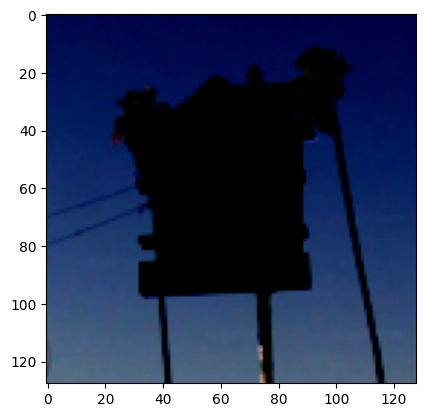

In [37]:
testset_path  = 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/svt1/test.pickle'
result_path= 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/results/results_test/'
pretrained_model_path = 'C:/Users/Aarohi Sudumbrekar/Desktop/dl_project-1/models/model-99'
testset = pd.read_pickle( testset_path )

is_train = tf.compat.v1.placeholder( tf.bool )
images_tf = tf.compat.v1.placeholder( tf.float32, [batch_size, 128, 128, 3], name="images")


In [ ]:
model = Model()

reconstruction = model.reconstruction_loss(images_tf, is_train)

# Applying bigger loss for overlapping region
tf.compat.v1.disable_v2_behavior()

sess = tf.compat.v1.InteractiveSession()

tf.compat.v1.global_variables_initializer().run()
saver.restore( sess, pretrained_model_path )

n = 0
for start,end in zip(
        range(0, len(testset), batch_size),
        range(batch_size, len(testset), batch_size)):
    
    test_image_paths = testset[:batch_size]['image_path'].values
    test_images_ori = map(lambda x: load_image(x), test_image_paths)

    test_images_crop = map(lambda x: crop_central(x, x=32, y=32), test_images_ori)
    test_images, test_crops, xs,ys = zip(*test_images_crop)
    for img,x,y in zip(test_images, xs, ys):
        img_rgb = (255. * (img + 1)/2.).astype(int)
        cv2.imwrite( os.path.join(result_path, 'img_'+str(n)+'.ori.jpg'), img_rgb)
        n+=1
        if n > 30: break